In [ ]:
import numpy as np
import tensorflow as tf
import keras
import os
import re
import random
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPool2D, Dropout, Input, LeakyReLU
from keras.preprocessing.image import img_to_array
from keras import Model
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Define the root directory
ROOT_DIR = '/content/drive/My Drive/'

In [ ]:
# from google.colab import files
# files.upload()  # Upload the kaggle.json file

# # Move the uploaded file to the required location
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os
image_path = '/content/drive/MyDrive/kaggle_datasets/photos'
sketches_path = '/content/drive/MyDrive/kaggle_datasets/sketches'

image_names = []
sketch_names = []

for i in os.listdir(image_path):
    image_names.append(i)

for i in os.listdir(sketches_path):
    sketch_names.append(i)
image_names = sorted(image_names)
sketch_names = sorted(sketch_names)
print("Images Names", image_names)
print("Sketch Names", sketch_names)

Images Names ['f-005-01.jpg', 'f-006-01.jpg', 'f-007-01.jpg', 'f-008-01.jpg', 'f-009-01.jpg', 'f-010-01.jpg', 'f-011-01.jpg', 'f-012-01.jpg', 'f-013-01.jpg', 'f-014-01.jpg', 'f-015-01.jpg', 'f-016-01.jpg', 'f-017-01.jpg', 'f-018-01.jpg', 'f-019-01.jpg', 'f-020-01.jpg', 'f-021-01.jpg', 'f-022-01.jpg', 'f-023-01.jpg', 'f-024-01.jpg', 'f-025-01.jpg', 'f-026-01.jpg', 'f-027-01.jpg', 'f-028-01.jpg', 'f-029-01.jpg', 'f-030-01.jpg', 'f-031-01.jpg', 'f-032-01.jpg', 'f-033-01.jpg', 'f-034-01.jpg', 'f-035-01.jpg', 'f-036-01.jpg', 'f-037-01.jpg', 'f-038-01.jpg', 'f-039-01.jpg', 'f-040-01.jpg', 'f-041-01.jpg', 'f-042-01.jpg', 'f-043-01.jpg', 'f1-001-01.jpg', 'f1-002-01.jpg', 'f1-003-01.jpg', 'f1-004-01.jpg', 'f1-005-01.jpg', 'f1-006-01.jpg', 'f1-007-01.jpg', 'f1-008-01.jpg', 'f1-009-01.jpg', 'f1-010-01.jpg', 'f1-011-01.jpg', 'f1-012-01.jpg', 'f1-013-01.jpg', 'f1-014-01.jpg', 'f1-015-01.jpg', 'm-008-01.jpg', 'm-009-01.jpg', 'm-010-01.jpg', 'm-011-01.jpg', 'm-012-01.jpg', 'm-013-01.jpg', 'm-014-01.j

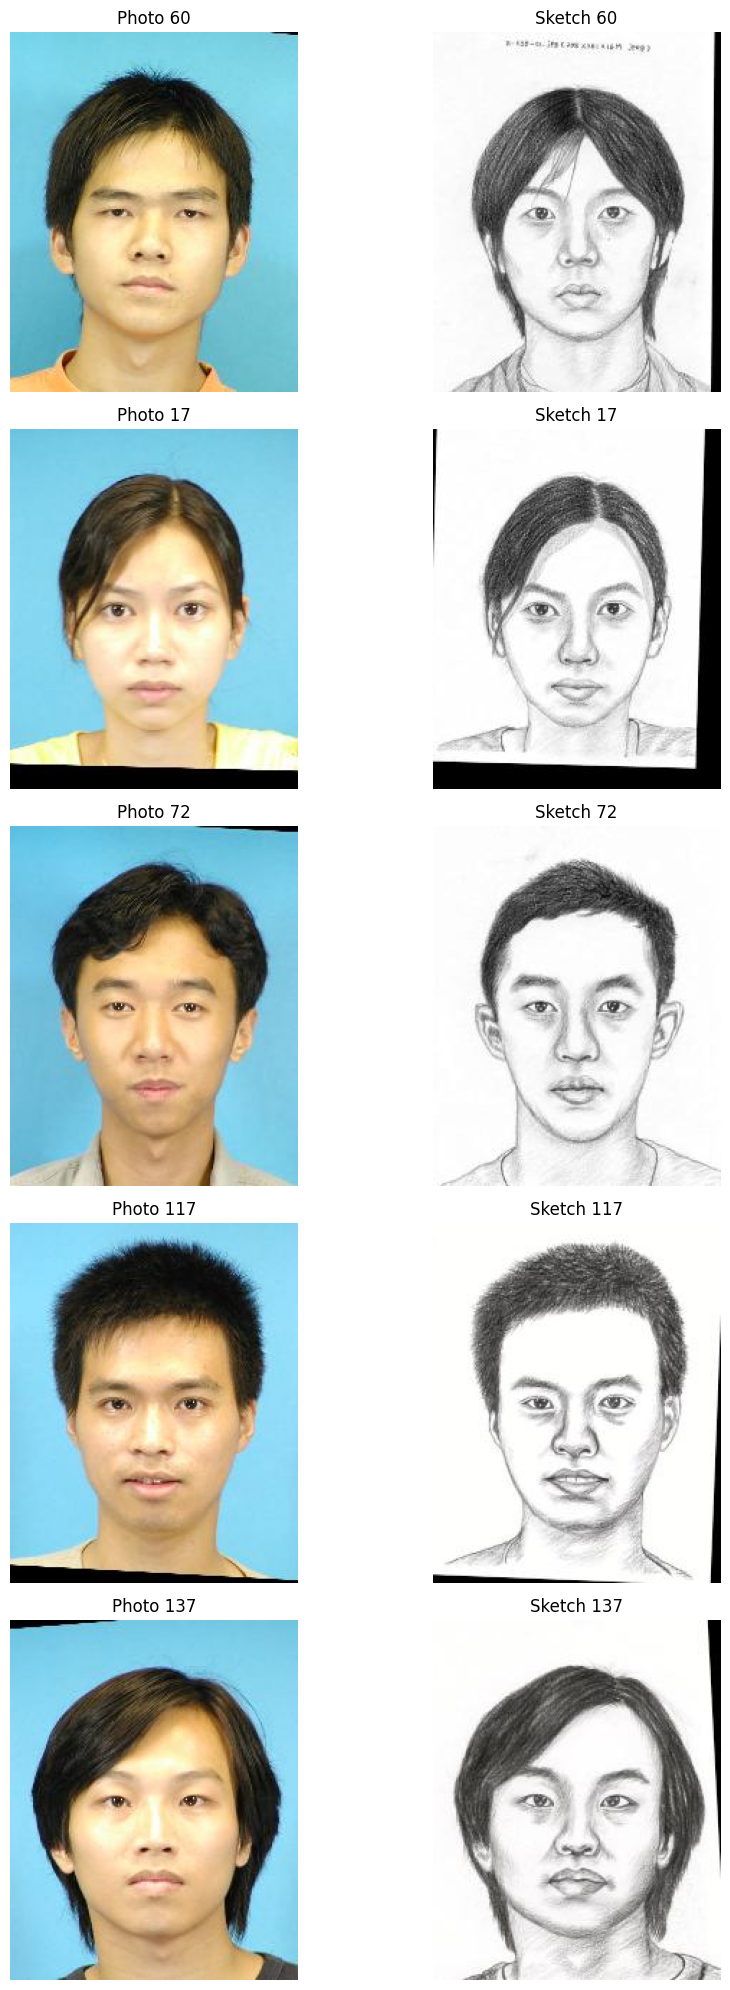

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Select five random indices
indices = random.sample(range(len(image_names)), 5)

# Plot the selected images and sketches
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i, idx in enumerate(indices):
    # Load and display the image
    img_path = os.path.join(image_path, image_names[idx])
    img = mpimg.imread(img_path)
    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Photo {idx}")

    # Load and display the sketch
    sketch_path = os.path.join(sketches_path, sketch_names[idx])
    sketch = mpimg.imread(sketch_path)
    axs[i, 1].imshow(sketch, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f"Sketch {idx}")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.utils import img_to_array
import keras.applications.resnet as resnet
import keras.backend as K
import tqdm
import cv2

In [ ]:
import cv2
import tqdm
import numpy as np

def augment_image(img):
    augmented_images = []
    # Horizontal Flip on Upright Image
    augmented_images.append(cv2.flip(img, 1))
    # Vertical Flip to Downright Image
    augmented_images.append(cv2.flip(img, -1))
    # Horizontal Flip on Downright Image
    augmented_images.append(cv2.flip(augmented_images[-1], 1))
    # Clockwise Rotate 90 degrees
    augmented_images.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
    # Clockwise Rotate 270 degrees
    augmented_images.append(cv2.flip(augmented_images[-1], 1))
    # Counter Clockwise Rotate 90 degrees
    augmented_images.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    # Counter Clockwise Rotate 270 degrees
    augmented_images.append(cv2.flip(img, 1))
    return augmented_images

size = 256
img_array = []
sketch_array = []

for img_name in tqdm.tqdm(image_names):
    img_path = os.path.join(image_path, img_name)
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    img = img.astype('float32') / 255
    img_array.append(img_to_array(img))
    img_array.extend(augment_image(img))

for img_name in tqdm.tqdm(sketch_names):
    img_path = os.path.join(sketches_path, img_name)
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    img = img.astype('float32') / 255
    sketch_array.append(img_to_array(img))
    sketch_array.extend(augment_image(img))


100%|██████████| 188/188 [01:06<00:00,  2.81it/s]


In [ ]:
print(f"The number of total Images is: {len(sketch_array)}")

The number of total Images is: 1504


In [ ]:
train_sketch_images = sketch_array[:1400]
train_original_images = img_array[:1400]
test_sketch_images = sketch_array[1400:]
test_original_images = img_array[1400:]
train_sketch_images = np.reshape(train_sketch_images, (len(train_sketch_images), int(size), int(size), 3))
train_original_images = np.reshape(train_original_images, (len(train_original_images), int(size), int(size), 3))
print('Train sketch images size: ', train_sketch_images.shape)
test_sketch_images = np.reshape(test_sketch_images, (len(test_sketch_images), int(size), int(size), 3))
test_original_images = np.reshape(test_original_images, (len(test_original_images), int(size), int(size), 3))
print('Test sketch images size: ', test_sketch_images.shape)

Train sketch images size:  (1400, 256, 256, 3)
Test sketch images size:  (104, 256, 256, 3)


In [ ]:
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras.models import Model

# Define the U-Net architecture
def unet_model(input_shape):
    # Input Layer
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    output = Conv2D(3, 1, activation='linear', padding='same')(conv9)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    return model

# Define the input shape
input_shape = (int(size), int(size), 3)

# Create the U-Net model
model = unet_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print the model summary
final_model = model
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
final_model.fit(train_original_images, train_sketch_images, epochs=3,
                validation_data=(test_original_images, test_sketch_images),
                verbose=1, callbacks=[early_stopping])

Epoch 1/3
44/44 [==============================] - 604s 14s/step - loss: 0.0520 - val_loss: 0.0479
Epoch 2/3
44/44 [==============================] - 602s 14s/step - loss: 0.0477 - val_loss: 0.0407
Epoch 3/3
44/44 [==============================] - 604s 14s/step - loss: 0.0472 - val_loss: 0.0371


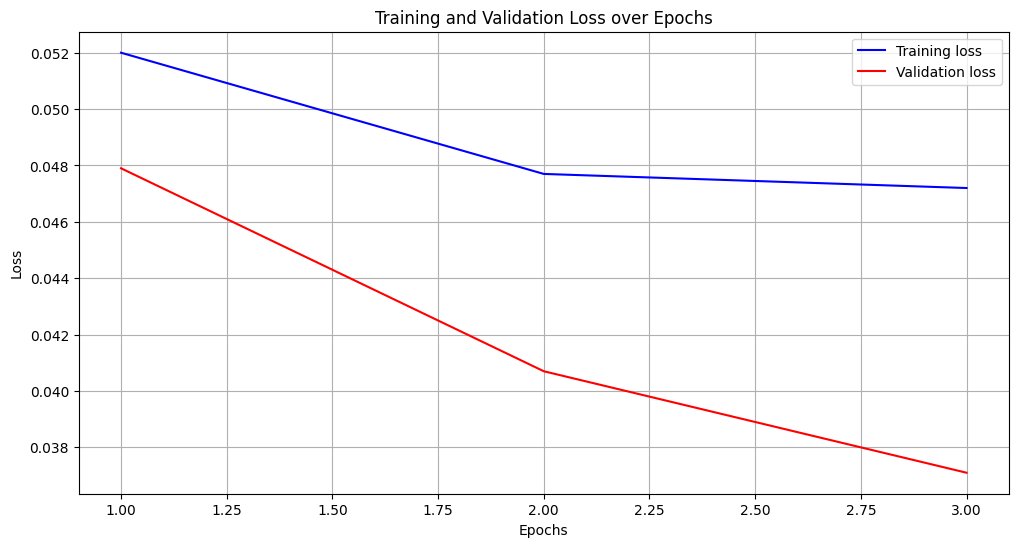

In [1]:
import matplotlib.pyplot as plt

# Loss values for each epoch
train_loss = [0.0520, 0.0477, 0.0472]
val_loss = [0.0479, 0.0407, 0.0371]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 153ms/step


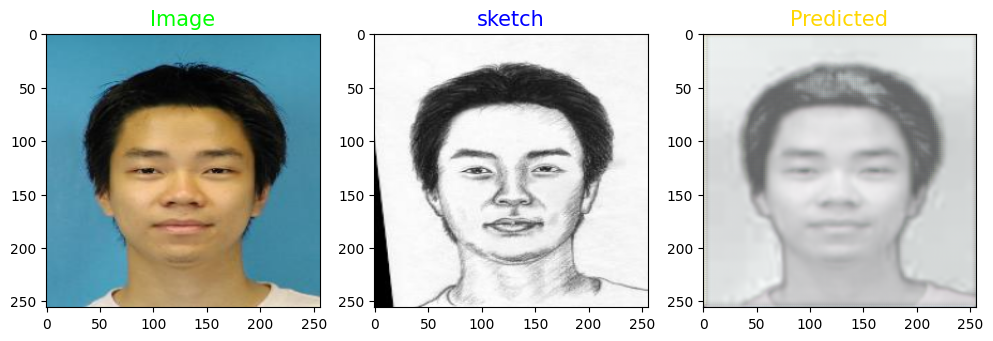

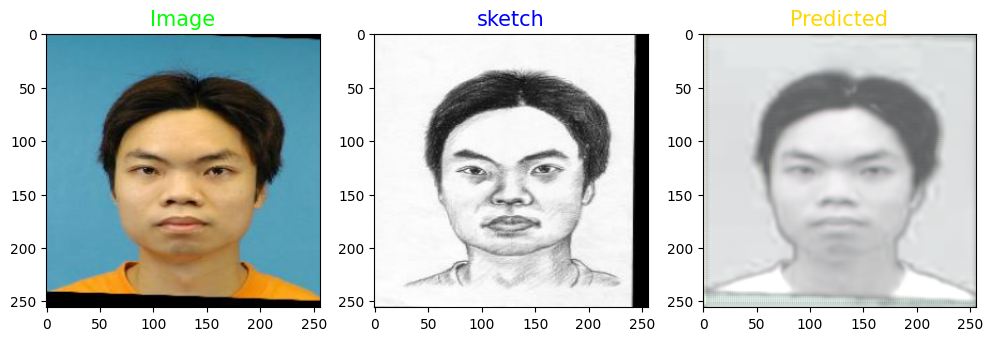

In [ ]:
def show_images(real, sketch, predicted):
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.title("Image", fontsize=15, color='Lime')
    plt.imshow(real)
    plt.subplot(1, 3, 2)
    plt.title("sketch", fontsize=15, color='Blue')
    plt.imshow(sketch)
    plt.subplot(1, 3, 3)
    plt.title("Predicted", fontsize=15, color='gold')
    plt.imshow(predicted)


ls = [i for i in range(0, 10, 8)]
for i in ls:
    predicted = np.clip(final_model.predict(test_original_images[i].reshape(1, size, size, 3)), 0.0, 1.0).reshape(size, size,                                                               3)
    show_images(test_original_images[i], test_sketch_images[i], predicted)

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Evaluate SSIM and PSNR metrics
def evaluate_model(model, test_images, test_labels):
    ssim_scores = []
    psnr_scores = []

    for i in range(len(test_images)):
        # Predict the output using the model
        predicted_output = model.predict(np.expand_dims(test_images[i], axis=0))[0]

        # Calculate SSIM and PSNR scores
        ssim_score = ssim(test_labels[i], predicted_output, multichannel=True)
        psnr_score = psnr(test_labels[i], predicted_output)

        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)

    # Calculate the average scores
    avg_ssim = sum(ssim_scores) / len(ssim_scores)
    avg_psnr = sum(psnr_scores) / len(psnr_scores)

    return avg_ssim, avg_psnr

# Assuming test_original_images and test_sketch_images are your test datasets
avg_ssim, avg_psnr = evaluate_model(final_model, test_original_images, test_sketch_images)

print(f"Average SSIM: {avg_ssim}")
print(f"Average PSNR: {avg_psnr}")


1/1 [==============================] - 0s 156ms/step


<ipython-input-17-8f7ed14cc4fd>:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(test_labels[i], predicted_output, multichannel=True)


1/1 [==============================] - 0s 151ms/step
Average SSIM: 0.7027499939386661
Average PSNR: 14.513551874505863


Hyperparameter Tuning

In [ ]:
from keras.optimizers import Adam
import numpy as np
import tqdm

# Define the range of hyperparameter values to tune
filters1_values = [32, 64, 128]
learning_rate_values = [0.001, 0.0001]

best_loss = float('inf')
best_filters1 = 0
best_learning_rate = 0

for filters1 in filters1_values:
    for learning_rate in learning_rate_values:

        input_shape = (int(size), int(size), 3)
        model = unet_model(input_shape)

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

        # Train the model
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(train_original_images, train_sketch_images, epochs=3,
                  validation_data=(test_original_images, test_sketch_images),
                  verbose=1, callbacks=[early_stopping])

        # Evaluate the model
        loss = model.evaluate(test_original_images, test_sketch_images)

        print(f"Filters1: {filters1}, Learning Rate: {learning_rate}, Loss: {loss}")

        # Update the best hyperparameters if the current model is better
        if loss < best_loss:
            best_loss = loss
            best_filters1 = filters1
            best_learning_rate = learning_rate

print(f"Best Loss: {best_loss}, Best Filters1: {best_filters1}, Best Learning Rate: {best_learning_rate}")
